In [1]:
import sys 
sys.path.append('../')

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optimizers
from tensorflow.keras import datasets
from tensorflow.keras.preprocessing.sequence import pad_sequences

from utils.callbacks import EarlyStopping
from utils.dataset import Hazumi1902

2022-06-06 14:51:53.773553: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
np.random.seed(123) 
torch.manual_seed(123) 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
'''
モデルの定義
'''

class LSTM(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__() 
        self.l1 = nn.LSTM(1463, hidden_dim, batch_first=True)
        self.l2 = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.l3 = nn.Linear(hidden_dim, 2) 

        nn.init.xavier_normal_(self.l1.weight_ih_l0)
        nn.init.orthogonal_(self.l1.weight_hh_l0) 
        nn.init.xavier_normal_(self.l2.weight_ih_l0)
        nn.init.orthogonal_(self.l2.weight_hh_l0) 
        nn.init.xavier_normal_(self.l3.weight) 

    def forward(self, x):
        h, _ = self.l1(x) 
        h, _ = self.l2(h)
        h = self.l3(h) # 入力hでいいのか
        y = F.softmax(h, dim=2)
        return y.squeeze()

testfilename :  ../data/dumpfiles/1902F2001.csv


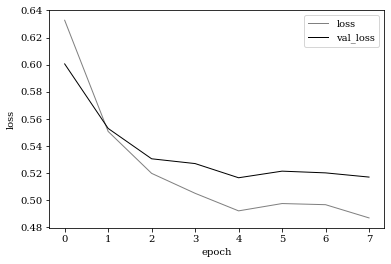

test_loss: 0.569, test_acc: 0.757
testfilename :  ../data/dumpfiles/1902F2002.csv


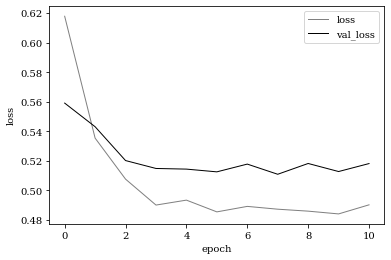

test_loss: 0.558, test_acc: 0.758
testfilename :  ../data/dumpfiles/1902F3001.csv


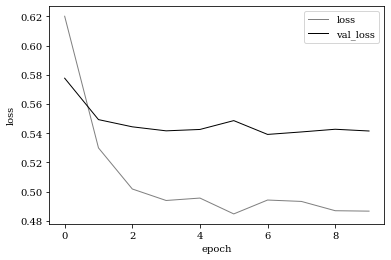

test_loss: 0.556, test_acc: 0.767
testfilename :  ../data/dumpfiles/1902F3002.csv


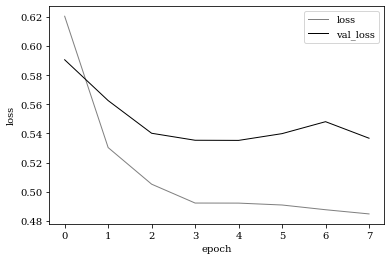

test_loss: 0.508, test_acc: 0.817
testfilename :  ../data/dumpfiles/1902F4001.csv


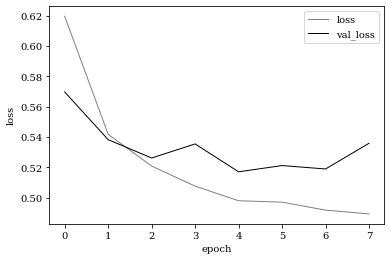

test_loss: 0.530, test_acc: 0.778
testfilename :  ../data/dumpfiles/1902F4002.csv


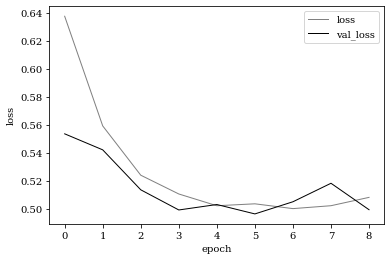

test_loss: 0.506, test_acc: 0.809
testfilename :  ../data/dumpfiles/1902F4003.csv


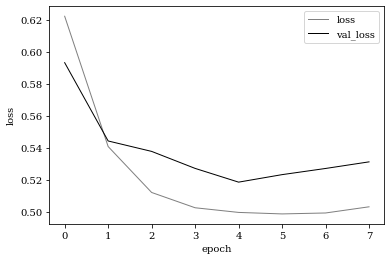

test_loss: 0.565, test_acc: 0.737
testfilename :  ../data/dumpfiles/1902F4004.csv


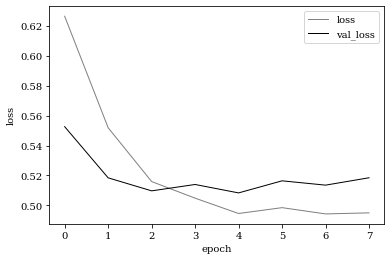

test_loss: 0.563, test_acc: 0.760
testfilename :  ../data/dumpfiles/1902F4005.csv


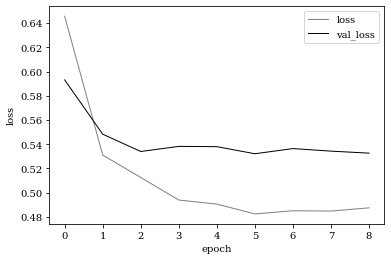

test_loss: 0.523, test_acc: 0.778
testfilename :  ../data/dumpfiles/1902F4006.csv


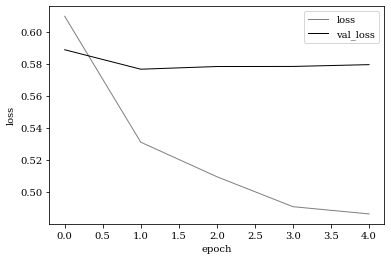

test_loss: 0.585, test_acc: 0.722
testfilename :  ../data/dumpfiles/1902F4008.csv


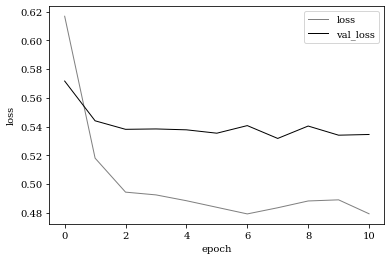

test_loss: 0.616, test_acc: 0.675
testfilename :  ../data/dumpfiles/1902F4009.csv


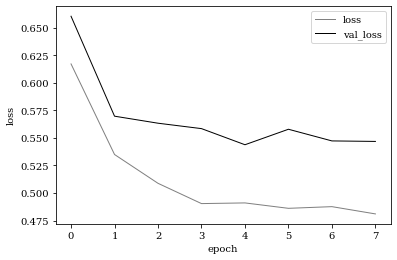

test_loss: 0.565, test_acc: 0.755
testfilename :  ../data/dumpfiles/1902F4010.csv


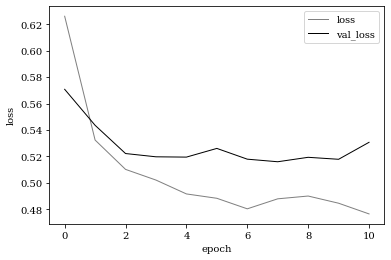

test_loss: 0.532, test_acc: 0.776
testfilename :  ../data/dumpfiles/1902F4011.csv


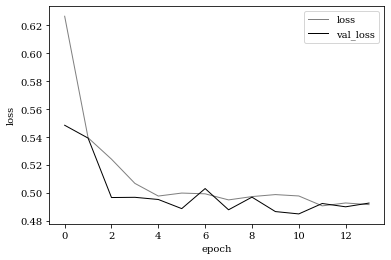

test_loss: 0.601, test_acc: 0.701
testfilename :  ../data/dumpfiles/1902F6001.csv


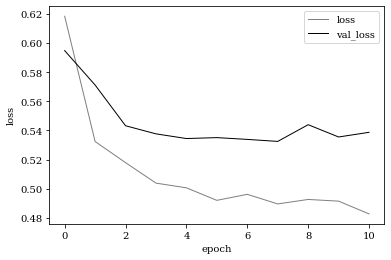

test_loss: 0.613, test_acc: 0.686
testfilename :  ../data/dumpfiles/1902F6002.csv


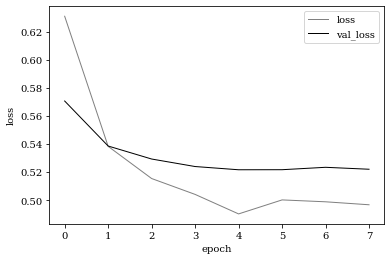

test_loss: 0.488, test_acc: 0.812
testfilename :  ../data/dumpfiles/1902F7001.csv


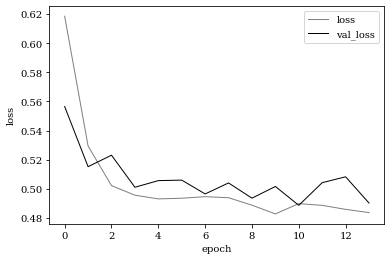

test_loss: 0.818, test_acc: 0.462
testfilename :  ../data/dumpfiles/1902F7002.csv


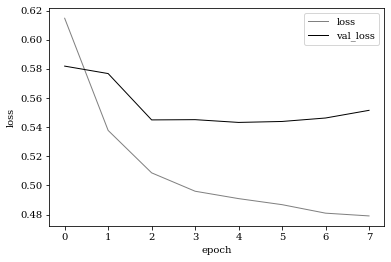

test_loss: 0.561, test_acc: 0.753
testfilename :  ../data/dumpfiles/1902F7003.csv


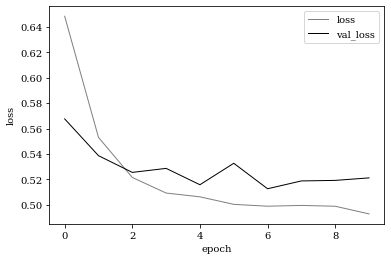

test_loss: 0.449, test_acc: 0.889
testfilename :  ../data/dumpfiles/1902M2001.csv


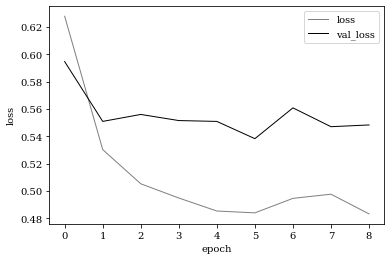

test_loss: 0.483, test_acc: 0.831
testfilename :  ../data/dumpfiles/1902M3001.csv


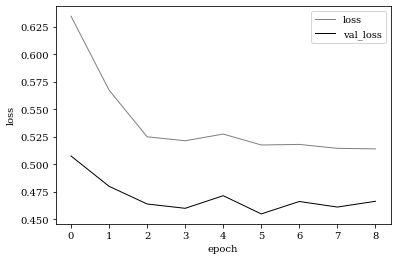

test_loss: 0.452, test_acc: 0.838
testfilename :  ../data/dumpfiles/1902M4001.csv


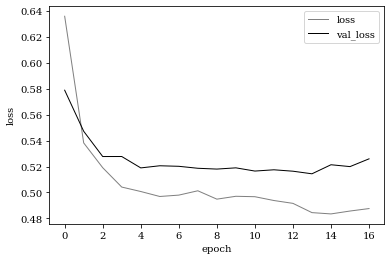

test_loss: 0.435, test_acc: 0.884
testfilename :  ../data/dumpfiles/1902M4002.csv


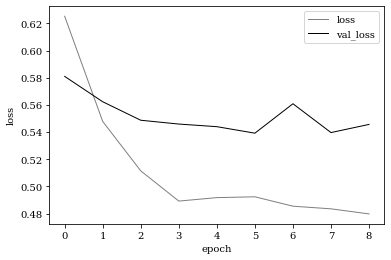

test_loss: 0.614, test_acc: 0.697
testfilename :  ../data/dumpfiles/1902M5001.csv


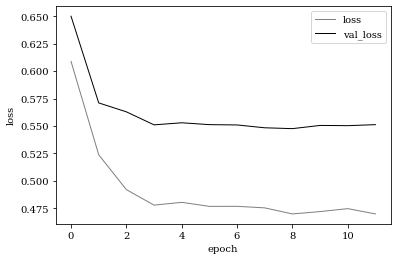

test_loss: 0.663, test_acc: 0.623
testfilename :  ../data/dumpfiles/1902M5002.csv


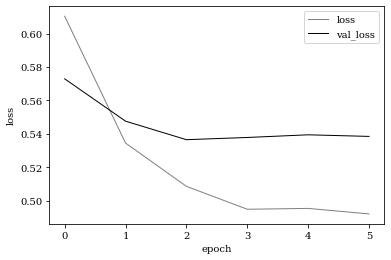

test_loss: 0.573, test_acc: 0.747
testfilename :  ../data/dumpfiles/1902M5003.csv


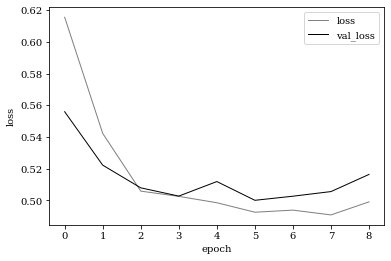

test_loss: 0.586, test_acc: 0.721
testfilename :  ../data/dumpfiles/1902M7001.csv


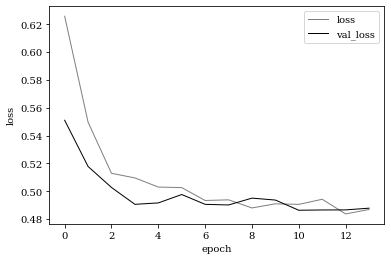

test_loss: 0.633, test_acc: 0.670
testfilename :  ../data/dumpfiles/1902M7002.csv


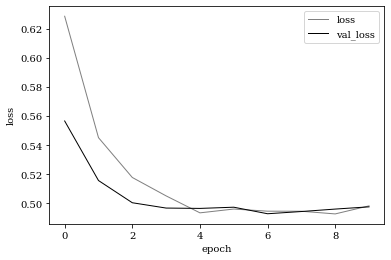

test_loss: 0.593, test_acc: 0.702
0.7449721865639709


In [29]:
'''
データの準備
'''

#target {1: emotion, 2: personality traits}
hazumi = Hazumi1902(target=1)

test_preds = [] 
test_ans = []
test_accs = {}

for testfile in hazumi.files:

    print('testfilename : ', testfile)

    x_train, x_test, t_train, t_test = hazumi.load_data(testfile=testfile)
    x_train, x_val, t_train, t_val = train_test_split(x_train, t_train, test_size=0.2)

    #標準化
    # maxlen = 50
    x_train = pad_sequences(x_train,padding='pre')
    x_val = pad_sequences(x_val,padding='pre')
    x_test = pad_sequences(x_test,padding='pre')

    t_train = pad_sequences(t_train, padding='pre')
    t_val = pad_sequences(t_val, padding='pre')
    t_test = pad_sequences(t_test, padding='pre')


    ''' 
    モデルの学習
    '''
    model = LSTM(200).to(device)
    criterion = nn.CrossEntropyLoss() #CrossEntropyLoss()?
    optimizer = optimizers.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), amsgrad=True)

    def compute_loss(t, y):
        return criterion(y, t)

    def train_step(x, t):
        x = torch.Tensor(x).to(device) 
        t = torch.LongTensor(t).to(device) 
        model.train() 
        preds = model(x) 
        loss = compute_loss(t.reshape(-1), preds.reshape(-1, 2))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        return loss, preds 

    def val_step(x, t):
        x = torch.Tensor(x).to(device) 
        t = torch.LongTensor(t).to(device)
        model.eval() 
        preds = model(x) 
        loss = criterion(preds.reshape(-1, 2), t.reshape(-1))

        return loss, preds

    epochs = 1000 
    batch_size = 2
    n_batches_train = len(x_train) // batch_size 
    n_batches_val = len(x_val) // batch_size
    es = EarlyStopping(patience=2, verbose=1) 

    hist = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}

    for epoch in range(epochs):
        train_loss = 0. 
        train_acc = 0. 
        val_loss = 0. 
        val_acc = 0. 
        x_, t_ = shuffle(x_train, t_train) 


        for batch in range(n_batches_train):
            start = batch * batch_size 
            end = start + batch_size
            loss, preds = train_step(x_[start:end], t_[start:end]) 
            train_loss += loss.item()
            train_acc += accuracy_score(t_[start:end].reshape(-1).tolist(), preds.argmax(dim=-1).reshape(-1).tolist())

        train_loss /= n_batches_train 
        train_acc /= n_batches_train 

        for batch in range(n_batches_val):
            start = batch * batch_size 
            end =start + batch_size
            loss, preds = val_step(x_val[start:end], t_val[start:end]) 
            val_loss += loss.item() 
            val_acc += accuracy_score(t_val[start:end].reshape(-1).tolist(), preds.argmax(dim=-1).reshape(-1).tolist())

        val_loss /= n_batches_val
        val_acc /= n_batches_val 

        hist['loss'].append(train_loss) 
        hist['accuracy'].append(train_acc) 
        hist['val_loss'].append(val_loss) 
        hist['val_accuracy'].append(val_acc) 

        # print('epoch: {}, loss: {:.3f}, acc: {:.3f}, val_loss: {:.3f}, val_acc: {:.3f}'.format(epoch+1, train_loss, train_acc, val_loss, val_acc))


        if es(val_loss):
            break
        
    '''
    モデルの評価
    ''' 

    loss = hist['loss'] 
    val_loss = hist['val_loss'] 

    fig = plt.figure() 
    plt.rc('font', family='serif') 
    plt.plot(range(len(loss)), loss, color='gray', linewidth=1, label='loss') 
    plt.plot(range(len(val_loss)), val_loss, color='black', linewidth=1, label='val_loss') 
    plt.xlabel('epoch') 
    plt.ylabel('loss') 
    plt.legend() 
    plt.show() 


    def test_step(x, t):
        return val_step(x, t) 

    loss, preds = test_step(x_test, t_test) 
    test_loss = loss.item() 
    test_acc = accuracy_score(t_test[0].reshape(-1).tolist(), preds.argmax(dim=-1).reshape(-1).tolist()) 

    print('test_loss: {:.3f}, test_acc: {:.3f}'.format(test_loss, test_acc))

    test_ans.extend(t_test.reshape(-1).tolist())
    test_preds.extend(preds.argmax(dim=-1).reshape(-1).tolist())

    test_accs[testfile] = accuracy_score(t_test[0].reshape(-1).tolist(), preds.argmax(dim=-1).reshape(-1).tolist()) 



print(accuracy_score(test_ans, test_preds))

In [ ]:
print(classification_report(test_ans, test_preds)) 

              precision    recall  f1-score   support

           0       0.72      0.43      0.54       816
           1       0.75      0.91      0.82      1521

    accuracy                           0.74      2337
   macro avg       0.74      0.67      0.68      2337
weighted avg       0.74      0.74      0.72      2337



In [26]:
test_accs.values()
a = [0.7387387387387387, 0.7878787878787878, 0.75, 0.7804878048780488,\
 0.8472222222222222, 0.8088235294117647, 0.7631578947368421, 0.8, 0.7777777777777778, 0.7391304347826086,\
  0.6987951807228916, 0.7547169811320755, 0.7653061224489796, 0.7012987012987013, 0.6744186046511628, 0.8, 0.44871794871794873, \
  0.7647058823529411, 0.8253968253968254, 0.8433734939759037, 0.8648648648648649, 0.8405797101449275, 0.6853932584269663\
  , 0.6229508196721312, 0.7676767676767676, 0.7906976744186046, 0.5568181818181818, 0.7023809523809523]
import statistics 
statistics.median(a)

0.7650060024009604